<a href="https://colab.research.google.com/github/Shraddhabhaskarani/IPYNB-Code-and-R-Code-117/blob/main/QSAR_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Single Colab cell: installs libs, uploads SDFs, runs QSAR pipeline (EC50->pEC50, fingerprints, RF models)
# Paste into one Colab cell and run.
import sys, os, io
print("Starting: will attempt to install required packages (rdkit-pypi, scikit-learn, pandas, numpy).")

# Try to import RDKit; if fails, pip-install rdkit-pypi (fast attempt). If that fails, we'll exit with guidance.
try:
    from rdkit import Chem
    print("RDKit already available.")
except Exception:
    print("RDKit not found — attempting pip install rdkit-pypi (may or may not work in Colab).")
    !pip install rdkit-pypi scikit-learn pandas numpy --quiet
    try:
        from rdkit import Chem
        print("RDKit import succeeded after pip install.")
    except Exception as e:
        print("Pip install of rdkit-pypi failed or RDKit still not importable. For a reliable install in Colab, use conda via condacolab:")
        print("1) pip install -q condacolab")
        print("2) import condacolab; condacolab.install()  # then restart runtime and run the cell again")
        raise e

# Now import the rest
import re, math
import numpy as np, pandas as pd
from rdkit.Chem import AllChem, MACCSkeys, RDKFingerprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Upload SDFs (or mount Drive if you prefer)
from google.colab import files
print("\nUpload your two SDF files when prompted (or cancel and mount Google Drive instead).")
print("If you prefer Drive: uncomment the drive.mount code below and adjust paths accordingly.")
uploaded = files.upload()  # click Choose Files and upload M2 and ACE SDF files

# Optionally, to use Drive instead of upload, uncomment:
# from google.colab import drive
# drive.mount('/content/drive')
# then set full paths for m2_file and ace_file from your Drive

# Determine filenames
uploaded_files = list(uploaded.keys())
if not uploaded_files:
    raise SystemExit("No files uploaded. Upload 'M2 Dataset.sdf' and 'ACE Dataset.sdf' (or mount Drive).")

# Try to automatically pick M2 and ACE by name heuristics
m2_file = None
ace_file = None
for fn in uploaded_files:
    low = fn.lower()
    if 'm2' in low or 'm-2' in low or 'm2 dataset' in low:
        m2_file = fn
    if 'ace' in low:
        ace_file = fn
# if not found heuristically and exactly two files uploaded, assign them
if (m2_file is None or ace_file is None) and len(uploaded_files) == 2:
    m2_file, ace_file = uploaded_files[0], uploaded_files[1]
# prompt user if still ambiguous
if m2_file is None:
    print("Could not auto-detect M2 file. Uploaded files:", uploaded_files)
    m2_file = input("Enter the filename to use as M2 SDF (exact name): ").strip()
if ace_file is None:
    print("Could not auto-detect ACE file. Uploaded files:", uploaded_files)
    ace_file = input("Enter the filename to use as ACE SDF (exact name): ").strip()

print(f"Using M2 file: {m2_file}")
print(f"Using ACE file: {ace_file}")

# Load SDFs into DataFrames
def read_sdf_to_df(path):
    suppl = Chem.SDMolSupplier(path)
    if suppl is None:
        raise IOError(f"RDKit SDMolSupplier failed for: {path}")
    rows = []
    none_count = 0
    for i,m in enumerate(suppl):
        if m is None:
            none_count += 1
            continue
        props = m.GetPropsAsDict()
        props["__smiles__"] = Chem.MolToSmiles(m)
        rows.append(props)
    df = pd.DataFrame(rows)
    print(f"Read {len(df)} parsed molecules from {path} (skipped {none_count} None entries).")
    return df

df_m2 = read_sdf_to_df(m2_file)
df_ace = read_sdf_to_df(ace_file)

# Show property keys to help user select names if unknown
print("\nM2 property keys (first molecule):")
try:
    print(list(df_m2.columns))
except Exception:
    pass
print("\nACE property keys (first molecule):")
try:
    print(list(df_ace.columns))
except Exception:
    pass

# Ask user to provide exact property names (with examples)
m2_col_input = input("\nEnter M2 activity property name (e.g. EC50 (nM)) or press Enter to auto-detect: ").strip()
ace_col_input = input("Enter ACE activity property name (e.g. pIC50) or press Enter to auto-detect: ").strip()

def find_activity_column(df):
    patterns = [r"ec\s*50", r"ec50", r"ic\s*50", r"ic50", r"p(ic|ec)50", r"pic50", r"pec50", r"activity"]
    for p in patterns:
        for c in df.columns:
            if re.search(p, c, re.I):
                return c
    # fallback numeric
    for c in df.columns:
        try:
            if pd.to_numeric(df[c].dropna().head(10)).shape[0] > 0:
                return c
        except Exception:
            continue
    return None

m2_col = m2_col_input if m2_col_input else find_activity_column(df_m2)
ace_col = ace_col_input if ace_col_input else find_activity_column(df_ace)

if not m2_col:
    raise SystemExit("M2 activity column not found. Use the --list-props approach or re-upload with correct file.")
if not ace_col:
    raise SystemExit("ACE activity column not found. Use the --list-props approach or re-upload with correct file.")

print(f"Using M2 activity column: {m2_col}")
print(f"Using ACE activity column: {ace_col}")

# Conversion helpers
def parse_first_number(s):
    if pd.isna(s):
        return None
    m = re.search(r"([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", str(s))
    return float(m.group(1)) if m else None

def to_molar(value, unit_hint):
    if value is None:
        return None
    if unit_hint:
        u = unit_hint.lower()
        if "nm" in u: return value * 1e-9
        if "um" in u or "µm" in u or "μm" in u: return value * 1e-6
        if "mm" in u: return value * 1e-3
        if u.strip() == "m": return value
    if abs(value) > 1: return value * 1e-9
    return value

def ec50_series_to_pEC50(series, header_unit_hint=None):
    pvals = []
    for v in series:
        if pd.isna(v):
            pvals.append(np.nan); continue
        s = str(v).strip()
        num = parse_first_number(s)
        unit_match = re.search(r"(nM|uM|µM|μM|mM|M|mol/L|molar)", s, re.I)
        unit = unit_match.group(0) if unit_match else None
        if unit:
            mol = to_molar(num, unit)
        else:
            mol = to_molar(num, header_unit_hint)
        if mol is None or mol <= 0:
            pvals.append(np.nan)
        else:
            pvals.append(-math.log10(mol))
    return pd.Series(pvals)

# Convert M2 EC50 -> pEC50
# if M2 column header contains unit hint like 'EC50 (nM)' use it
m = re.search(r"\(([^)]+)\)", m2_col)
unit_hint_m2 = m.group(1) if m else None
print("\nConverting M2 EC50 -> pEC50 (using header hint: {})...".format(unit_hint_m2))
df_m2["pEC50"] = ec50_series_to_pEC50(df_m2[m2_col], header_unit_hint=unit_hint_m2)
print("M2 pEC50 summary:")
print(df_m2["pEC50"].describe())

# For ACE: detect if values are already p-values or convert similarly
ace_sample = df_ace[ace_col].dropna().astype(str).head(20).tolist()
looks_like_p = False
if ace_sample:
    numeric = []
    for s in ace_sample:
        s2 = s.strip()
        if re.match(r"^[\d\.Eed+-]+$", s2):
            try:
                numeric.append(float(s2))
            except:
                pass
    if len(numeric) >= 3 and all(3.5 <= x <= 12.5 for x in numeric):
        looks_like_p = True

if looks_like_p:
    print("\nACE column looks like p-values; copying to pEC50.")
    df_ace["pEC50"] = pd.to_numeric(df_ace[ace_col], errors="coerce")
else:
    print("\nACE column does not look like p-values; attempting conversion (same heuristic as M2).")
    m2h = re.search(r"\(([^)]+)\)", ace_col)
    unit_hint_ace = m2h.group(1) if m2h else None
    df_ace["pEC50"] = ec50_series_to_pEC50(df_ace[ace_col], header_unit_hint=unit_hint_ace)
print("ACE pEC50 summary:")
print(df_ace["pEC50"].describe())

# Fingerprints
def compute_fps(smiles_list):
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    Xm, Xmac, Xrd = [], [], []
    valid_idx = []
    for i,m in enumerate(mols):
        if m is None: continue
        valid_idx.append(i)
        Xm.append(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048))
        Xmac.append(MACCSkeys.GenMACCSKeys(m))
        Xrd.append(RDKFingerprint(m, fpSize=2048))
    to_arr = lambda bv: np.array(list(bv), dtype=int)
    X_m = np.array([to_arr(x) for x in Xm], dtype=int) if Xm else np.empty((0,2048), dtype=int)
    X_ma = np.array([to_arr(x) for x in Xmac], dtype=int) if Xmac else np.empty((0,167), dtype=int)
    X_r = np.array([to_arr(x) for x in Xrd], dtype=int) if Xrd else np.empty((0,2048), dtype=int)
    return valid_idx, X_m, X_ma, X_r

print("\nComputing fingerprints for M2...")
idx_m2, X_m2_morgan, X_m2_maccs, X_m2_rdk = compute_fps(df_m2["__smiles__"].astype(str).tolist())
y_m2 = df_m2["pEC50"].reset_index(drop=True).iloc[idx_m2].astype(float).reset_index(drop=True)
mask = ~np.isnan(y_m2)
X_m2_morgan, X_m2_maccs, X_m2_rdk, y_m2 = X_m2_morgan[mask.values], X_m2_maccs[mask.values], X_m2_rdk[mask.values], y_m2[mask].values
print(f"M2 shapes: Morgan {X_m2_morgan.shape}, MACCS {X_m2_maccs.shape}, RDK {X_m2_rdk.shape}")

print("\nComputing fingerprints for ACE...")
idx_ace, X_ace_morgan, X_ace_maccs, X_ace_rdk = compute_fps(df_ace["__smiles__"].astype(str).tolist())
y_ace = df_ace["pEC50"].reset_index(drop=True).iloc[idx_ace].astype(float).reset_index(drop=True)
mask2 = ~np.isnan(y_ace)
X_ace_morgan, X_ace_maccs, X_ace_rdk, y_ace = X_ace_morgan[mask2.values], X_ace_maccs[mask2.values], X_ace_rdk[mask2.values], y_ace[mask2].values
print(f"ACE shapes: Morgan {X_ace_morgan.shape}, MACCS {X_ace_maccs.shape}, RDK {X_ace_rdk.shape}")

# Model evaluate function
def eval_rf(X, y):
    if X.shape[0] < 6:
        return {"note":"too few samples","n":int(X.shape[0])}
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1)
    model.fit(Xtr, ytr)
    yp = model.predict(Xte)
    res = {
        "r2_holdout": float(r2_score(yte, yp)),
        "rmse_holdout": float(mean_squared_error(yte, yp, squared=False)),
        "mae_holdout": float(mean_absolute_error(yte, yp))
    }
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        cv_r2 = cross_val_score(model, X, y, cv=kf, scoring="r2", n_jobs=-1)
        cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1))
        res.update({
            "cv_r2_mean": float(np.nanmean(cv_r2)),
            "cv_r2_std": float(np.nanstd(cv_r2)),
            "cv_rmse_mean": float(np.nanmean(cv_rmse)),
            "cv_rmse_std": float(np.nanstd(cv_rmse))
        })
    except Exception as e:
        res["cv_error"] = str(e)
    return res

print("\nEvaluating models...")
print("M2 Morgan:", eval_rf(X_m2_morgan, y_m2))
print("M2 MACCS:", eval_rf(X_m2_maccs, y_m2))
print("M2 RDK:", eval_rf(X_m2_rdk, y_m2))
print("ACE Morgan:", eval_rf(X_ace_morgan, y_ace))
print("ACE MACCS:", eval_rf(X_ace_maccs, y_ace))
print("ACE RDK:", eval_rf(X_ace_rdk, y_ace))

# Save outputs to /content
outdir = "/content/qsar_outputs"
os.makedirs(outdir, exist_ok=True)
df_m2.to_csv(os.path.join(outdir, "M2_processed_with_pEC50.csv"), index=False)
df_ace.to_csv(os.path.join(outdir, "ACE_processed_with_pEC50.csv"), index=False)
np.savez_compressed(os.path.join(outdir, "M2_fps_y.npz"), morgan=X_m2_morgan, maccs=X_m2_maccs, rdk=X_m2_rdk, y=y_m2)
np.savez_compressed(os.path.join(outdir, "ACE_fps_y.npz"), morgan=X_ace_morgan, maccs=X_ace_maccs, rdk=X_ace_rdk, y=y_ace)
print(f"\nSaved outputs to {outdir}. Use the left Colab Files pane to download results.")


Starting: will attempt to install required packages (rdkit-pypi, scikit-learn, pandas, numpy).
RDKit already available.

Upload your two SDF files when prompted (or cancel and mount Google Drive instead).
If you prefer Drive: uncomment the drive.mount code below and adjust paths accordingly.


Saving ACE Dataset.sdf to ACE Dataset (1).sdf
Saving M2 Dataset.sdf to M2 Dataset (2).sdf
Using M2 file: M2 Dataset (2).sdf
Using ACE file: ACE Dataset (1).sdf
Read 44 parsed molecules from M2 Dataset (2).sdf (skipped 0 None entries).
Read 49 parsed molecules from ACE Dataset (1).sdf (skipped 0 None entries).

M2 property keys (first molecule):
['Target', 'EC50 (nM)', '__smiles__']

ACE property keys (first molecule):
['Target', 'pIC50', 'Division', '__smiles__']

Enter M2 activity property name (e.g. EC50 (nM)) or press Enter to auto-detect: 
Enter ACE activity property name (e.g. pIC50) or press Enter to auto-detect: 
Using M2 activity column: EC50 (nM)
Using ACE activity column: pIC50

Converting M2 EC50 -> pEC50 (using header hint: nM)...
M2 pEC50 summary:
count    44.000000
mean      5.806590
std       0.899321
min       3.820000
25%       5.207500
50%       5.850001
75%       6.354998
max       7.349984
Name: pEC50, dtype: float64

ACE column does not look like p-values; attempti

[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerat

M2 shapes: Morgan (44, 2048), MACCS (44, 167), RDK (44, 2048)

Computing fingerprints for ACE...
ACE shapes: Morgan (49, 2048), MACCS (49, 167), RDK (49, 2048)

Evaluating models...


[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerator
[15:35:19] DEPRECATION WARNING: please use MorganGenerat

TypeError: got an unexpected keyword argument 'squared'

In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 52.5 MB/s eta 0:00:00


In [18]:
# Final one-cell QSAR pipeline for Colab
# Paste into a single Colab cell and run.
import os, sys, math, re
from pathlib import Path

# Try to import RDKit; fallback to pip install rdkit-pypi (quick attempt)
try:
    from rdkit import Chem
    from rdkit.Chem import AllChem, MACCSkeys, RDKFingerprint
    print("RDKit available.")
except Exception:
    print("RDKit not found — attempting pip install rdkit-pypi (may or may not work).")
    !pip install rdkit-pypi scikit-learn pandas numpy --quiet
    try:
        from rdkit import Chem
        from rdkit.Chem import AllChem, MACCSkeys, RDKFingerprint
        print("RDKit import succeeded after pip install.")
    except Exception as e:
        print("Automatic pip install failed. In Colab, prefer Conda via condacolab:")
        print("  !pip install -q condacolab")
        print("  import condacolab; condacolab.install()")
        raise e

# Standard imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Upload or mount Drive ---
from google.colab import files
print("\nUpload your SDF files (M2 and ACE). When upload dialog appears, choose both files.")
uploaded = files.upload()  # choose files

# If you prefer drive, uncomment and use that instead of upload above:
# from google.colab import drive
# drive.mount('/content/drive')
# then set m2_file and ace_file to full paths in drive.

# Determine file names
uploaded_files = list(uploaded.keys())
if len(uploaded_files) == 0:
    raise SystemExit("No files uploaded. Upload M2 and ACE SDF files then re-run.")
# Simple heuristics for filenames
m2_file = None
ace_file = None
for fn in uploaded_files:
    low = fn.lower()
    if 'm2' in low and m2_file is None:
        m2_file = fn
    if 'ace' in low and ace_file is None:
        ace_file = fn
# If not auto-detected and exactly two files, assign them
if (m2_file is None or ace_file is None) and len(uploaded_files) == 2:
    m2_file, ace_file = uploaded_files[0], uploaded_files[1]
# If still ambiguous ask user
if m2_file is None:
    print("Uploaded files:", uploaded_files)
    m2_file = input("Enter the exact filename to use as M2 SDF: ").strip()
if ace_file is None:
    print("Uploaded files:", uploaded_files)
    ace_file = input("Enter the exact filename to use as ACE SDF: ").strip()

print(f"\nUsing M2 file: {m2_file}")
print(f"Using ACE file: {ace_file}")

# --- Read SDFs into DataFrames ---
def read_sdf_to_df(path):
    suppl = Chem.SDMolSupplier(str(path))
    if suppl is None:
        raise IOError(f"RDKit SDMolSupplier failed for: {path}")
    rows = []
    skipped = 0
    for m in suppl:
        if m is None:
            skipped += 1
            continue
        props = m.GetPropsAsDict()
        props["__smiles__"] = Chem.MolToSmiles(m)
        rows.append(props)
    df = pd.DataFrame(rows)
    print(f"Read {len(df)} parsed molecules from {path} (skipped {skipped} None entries).")
    return df

df_m2 = read_sdf_to_df(m2_file)
df_ace = read_sdf_to_df(ace_file)

print("\nM2 property columns:", list(df_m2.columns))
print("ACE property columns:", list(df_ace.columns))

# Prompt for activity columns (press Enter to auto-detect)
def find_activity_column(df):
    patterns = [r"ec\s*50", r"ec50", r"ic\s*50", r"ic50", r"p(ic|ec)50", r"pIC50", r"pEC50", r"activity"]
    for p in patterns:
        for c in df.columns:
            if re.search(p, c, re.I):
                return c
    # fallback numeric-like column
    for c in df.columns:
        try:
            sample = pd.to_numeric(df[c].dropna().head(10))
            if len(sample) > 0:
                return c
        except Exception:
            continue
    return None

m2_col_input = input("\nEnter M2 activity property name (e.g. EC50 (nM)) or press Enter to auto-detect: ").strip()
ace_col_input = input("Enter ACE activity property name (e.g. pIC50) or press Enter to auto-detect: ").strip()

m2_col = m2_col_input if m2_col_input else find_activity_column(df_m2)
ace_col = ace_col_input if ace_col_input else find_activity_column(df_ace)

if not m2_col or not ace_col:
    print("Could not detect activity columns. Use --list-props style snippet to inspect SDF keys.")
    raise SystemExit(1)

print(f"Using M2 activity column: {m2_col}")
print(f"Using ACE activity column: {ace_col}")

# --- Conversion helpers ---
def parse_first_number(s):
    if pd.isna(s):
        return None
    m = re.search(r"([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", str(s))
    return float(m.group(1)) if m else None

def to_molar(value, unit_hint):
    if value is None:
        return None
    if unit_hint:
        u = unit_hint.lower()
        if "nm" in u: return value * 1e-9
        if "um" in u or "µm" in u or "μm" in u: return value * 1e-6
        if "mm" in u: return value * 1e-3
        if u.strip() == "m": return value
    # heuristic: if >1 assume nM
    if abs(value) > 1: return value * 1e-9
    return value

def ec50_series_to_pEC50(series, header_unit_hint=None):
    pvals = []
    for v in series:
        if pd.isna(v):
            pvals.append(np.nan); continue
        s = str(v).strip()
        num = parse_first_number(s)
        unit_match = re.search(r"(nM|uM|µM|μM|mM|M|mol/L|molar)", s, re.I)
        unit = unit_match.group(0) if unit_match else None
        if unit:
            mol = to_molar(num, unit)
        else:
            mol = to_molar(num, header_unit_hint)
        if mol is None or mol <= 0:
            pvals.append(np.nan)
        else:
            pvals.append(-math.log10(mol))
    return pd.Series(pvals)

# Convert M2 EC50 -> pEC50 using header hint if present
m = re.search(r"\(([^)]+)\)", m2_col)
m2_hint = m.group(1) if m else None
print(f"\nConverting M2 EC50 -> pEC50 using header hint: {m2_hint}")
df_m2["pEC50"] = ec50_series_to_pEC50(df_m2[m2_col], header_unit_hint=m2_hint)
print("M2 pEC50 summary:\n", df_m2["pEC50"].describe())

# ACE: if looks like p-values (~4-12) copy, else convert with same heuristic
ace_sample = df_ace[ace_col].dropna().astype(str).head(30).tolist()
looks_like_p = False
numeric = []
for s in ace_sample:
    s2 = s.strip()
    if re.match(r"^[\d\.Eed+-]+$", s2):
        try:
            numeric.append(float(s2))
        except: pass
if len(numeric) >= 3 and all(3.5 <= x <= 12.5 for x in numeric):
    looks_like_p = True

if looks_like_p:
    print("\nACE column looks like p-values -> copy to pEC50")
    df_ace["pEC50"] = pd.to_numeric(df_ace[ace_col], errors="coerce")
else:
    print("\nACE column does not look like p-values -> attempting conversion")
    m = re.search(r"\(([^)]+)\)", ace_col)
    ace_hint = m.group(1) if m else None
    df_ace["pEC50"] = ec50_series_to_pEC50(df_ace[ace_col], header_unit_hint=ace_hint)

print("ACE pEC50 summary:\n", df_ace["pEC50"].describe())

# --- Fingerprints ---
def compute_fps(smiles_list):
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    Xm, Xmac, Xrd = [], [], []
    valid_idx = []
    for i,m in enumerate(mols):
        if m is None: continue
        valid_idx.append(i)
        Xm.append(AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048))
        Xmac.append(MACCSkeys.GenMACCSKeys(m))
        Xrd.append(RDKFingerprint(m, fpSize=2048))
    to_arr = lambda bv: np.array(list(bv), dtype=int)
    X_m = np.array([to_arr(x) for x in Xm], dtype=int) if Xm else np.empty((0,2048), dtype=int)
    X_ma = np.array([to_arr(x) for x in Xmac], dtype=int) if Xmac else np.empty((0,167), dtype=int)
    X_r = np.array([to_arr(x) for x in Xrd], dtype=int) if Xrd else np.empty((0,2048), dtype=int)
    return valid_idx, X_m, X_ma, X_r

print("\nComputing fingerprints for M2...")
idx_m2, X_m2_morgan, X_m2_maccs, X_m2_rdk = compute_fps(df_m2["__smiles__"].astype(str).tolist())
y_m2 = df_m2["pEC50"].reset_index(drop=True).iloc[idx_m2].astype(float).reset_index(drop=True)
mask_m2 = ~np.isnan(y_m2)
X_m2_morgan, X_m2_maccs, X_m2_rdk, y_m2 = X_m2_morgan[mask_m2.values], X_m2_maccs[mask_m2.values], X_m2_rdk[mask_m2.values], y_m2[mask_m2].values
print("M2 shapes:", X_m2_morgan.shape, X_m2_maccs.shape, X_m2_rdk.shape)

print("\nComputing fingerprints for ACE...")
idx_ace, X_ace_morgan, X_ace_maccs, X_ace_rdk = compute_fps(df_ace["__smiles__"].astype(str).tolist())
y_ace = df_ace["pEC50"].reset_index(drop=True).iloc[idx_ace].astype(float).reset_index(drop=True)
mask_ace = ~np.isnan(y_ace)
X_ace_morgan, X_ace_maccs, X_ace_rdk, y_ace = X_ace_morgan[mask_ace.values], X_ace_maccs[mask_ace.values], X_ace_rdk[mask_ace.values], y_ace[mask_ace].values
print("ACE shapes:", X_ace_morgan.shape, X_ace_maccs.shape, X_ace_rdk.shape)

# --- Modeling (compat-friendly, explicit RMSE calc) ---
def eval_rf_compat(X, y, n_estimators=250):
    out = {}
    n = X.shape[0]
    out["n_samples"] = int(n)
    if n < 6:
        out["note"] = "too few samples"
        return out
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    mse = mean_squared_error(yte, ypred)
    out["r2_holdout"] = float(r2_score(yte, ypred))
    out["rmse_holdout"] = float(np.sqrt(mse))
    out["mae_holdout"] = float(mean_absolute_error(yte, ypred))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    try:
        cv_r2 = cross_val_score(model, X, y, cv=kf, scoring="r2", n_jobs=-1)
        cv_neg_mse = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error", n_jobs=-1)
        cv_rmse = np.sqrt(-cv_neg_mse)
        out["cv_r2_mean"] = float(np.nanmean(cv_r2))
        out["cv_r2_std"] = float(np.nanstd(cv_r2))
        out["cv_rmse_mean"] = float(np.nanmean(cv_rmse))
        out["cv_rmse_std"] = float(np.nanstd(cv_rmse))
    except Exception as e:
        out["cv_error"] = str(e)
    return out

print("\nEvaluating models (compat-version)...")
print("M2 Morgan:", eval_rf_compat(X_m2_morgan, y_m2))
print("M2 MACCS:", eval_rf_compat(X_m2_maccs, y_m2))
print("M2 RDK:", eval_rf_compat(X_m2_rdk, y_m2))
print("ACE Morgan:", eval_rf_compat(X_ace_morgan, y_ace))
print("ACE MACCS:", eval_rf_compat(X_ace_maccs, y_ace))
print("ACE RDK:", eval_rf_compat(X_ace_rdk, y_ace))

# --- Save outputs ---
outdir = "/content/qsar_outputs"
os.makedirs(outdir, exist_ok=True)
df_m2.to_csv(os.path.join(outdir, "M2_processed_with_pEC50.csv"), index=False)
df_ace.to_csv(os.path.join(outdir, "ACE_processed_with_pEC50.csv"), index=False)
np.savez_compressed(os.path.join(outdir, "M2_fps_y.npz"), morgan=X_m2_morgan, maccs=X_m2_maccs, rdk=X_m2_rdk, y=y_m2)
np.savez_compressed(os.path.join(outdir, "ACE_fps_y.npz"), morgan=X_ace_morgan, maccs=X_ace_maccs, rdk=X_ace_rdk, y=y_ace)
print(f"\nSaved outputs to {outdir}. Use the Colab file browser to download.")


RDKit available.

Upload your SDF files (M2 and ACE). When upload dialog appears, choose both files.


Saving ACE Dataset.sdf to ACE Dataset (2).sdf
Saving M2 Dataset.sdf to M2 Dataset (3).sdf

Using M2 file: M2 Dataset (3).sdf
Using ACE file: ACE Dataset (2).sdf
Read 44 parsed molecules from M2 Dataset (3).sdf (skipped 0 None entries).
Read 49 parsed molecules from ACE Dataset (2).sdf (skipped 0 None entries).

M2 property columns: ['Target', 'EC50 (nM)', '__smiles__']
ACE property columns: ['Target', 'pIC50', 'Division', '__smiles__']

Enter M2 activity property name (e.g. EC50 (nM)) or press Enter to auto-detect: 
Enter ACE activity property name (e.g. pIC50) or press Enter to auto-detect: 
Using M2 activity column: EC50 (nM)
Using ACE activity column: pIC50

Converting M2 EC50 -> pEC50 using header hint: nM
M2 pEC50 summary:
 count    44.000000
mean      5.806590
std       0.899321
min       3.820000
25%       5.207500
50%       5.850001
75%       6.354998
max       7.349984
Name: pEC50, dtype: float64

ACE column does not look like p-values -> attempting conversion
ACE pEC50 summar

[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerat

M2 shapes: (44, 2048) (44, 167) (44, 2048)

Computing fingerprints for ACE...
ACE shapes: (49, 2048) (49, 167) (49, 2048)

Evaluating models (compat-version)...


[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerator
[15:48:07] DEPRECATION WARNING: please use MorganGenerat

M2 Morgan: {'n_samples': 44, 'r2_holdout': 0.44303215647135363, 'rmse_holdout': 0.5173127730816718, 'mae_holdout': 0.44989094539115665, 'cv_r2_mean': 0.28984978388571775, 'cv_r2_std': 0.19874209209693366, 'cv_rmse_mean': 0.6908258205030734, 'cv_rmse_std': 0.14043602103423708}
M2 MACCS: {'n_samples': 44, 'r2_holdout': 0.1917235190785841, 'rmse_holdout': 0.623186607757699, 'mae_holdout': 0.506900478066268, 'cv_r2_mean': 0.5276423135770946, 'cv_r2_std': 0.1959970391511665, 'cv_rmse_mean': 0.539774771828079, 'cv_rmse_std': 0.04509561792658958}
M2 RDK: {'n_samples': 44, 'r2_holdout': 0.07239397290560856, 'rmse_holdout': 0.6676055242948866, 'mae_holdout': 0.4738843862475255, 'cv_r2_mean': 0.23501061599947973, 'cv_r2_std': 0.39511297852653715, 'cv_rmse_mean': 0.6754310671504078, 'cv_rmse_std': 0.06693956650157004}
ACE Morgan: {'n_samples': 49, 'r2_holdout': 0.7009416745080934, 'rmse_holdout': 0.04313161816478521, 'mae_holdout': 0.028474210737810778, 'cv_r2_mean': 0.8278615245753471, 'cv_r2_st

In [19]:
# Cell 1: download pipeline outputs to your local machine
from google.colab import files
outdir = '/content/qsar_outputs'
files_to_download = [
    'qsar_model_results.csv',
    'M2_processed_with_pEC50.csv',
    'ACE_processed_with_pEC50.csv',
    'M2_fps_y.npz',
    'ACE_fps_y.npz'
]
for fn in files_to_download:
    path = f"{outdir}/{fn}"
    print("Downloading:", path)
    try:
        files.download(path)
    except Exception as e:
        print("Could not download", path, ":", e)


Downloading: /content/qsar_outputs/qsar_model_results.csv
Could not download /content/qsar_outputs/qsar_model_results.csv : Cannot find file: /content/qsar_outputs/qsar_model_results.csv
Downloading: /content/qsar_outputs/M2_processed_with_pEC50.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: /content/qsar_outputs/ACE_processed_with_pEC50.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: /content/qsar_outputs/M2_fps_y.npz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading: /content/qsar_outputs/ACE_fps_y.npz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

\n--- M2 Morgan (ECFP4,2048)


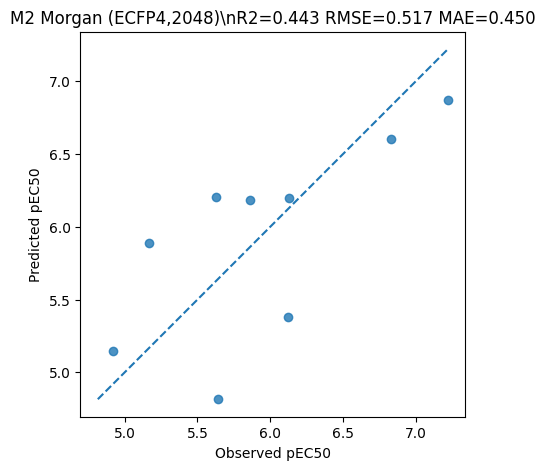

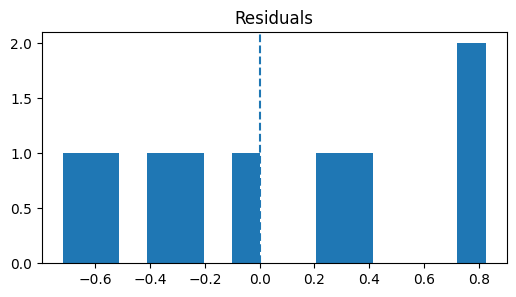

\n--- M2 MACCS


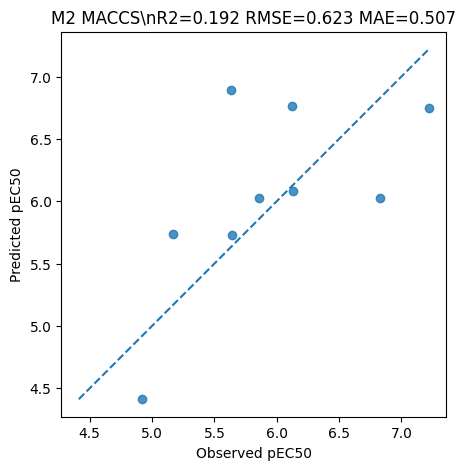

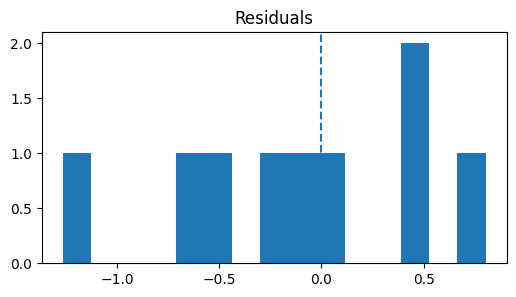

\n--- M2 RDKit (2048)


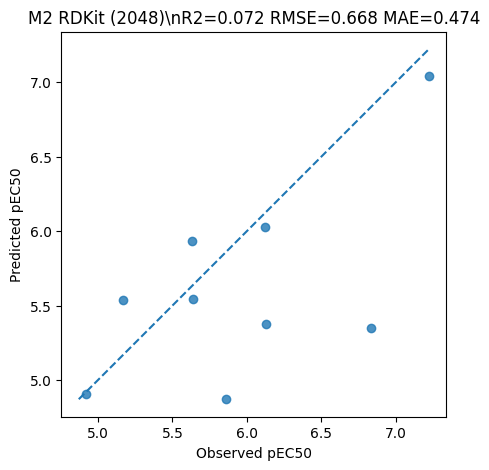

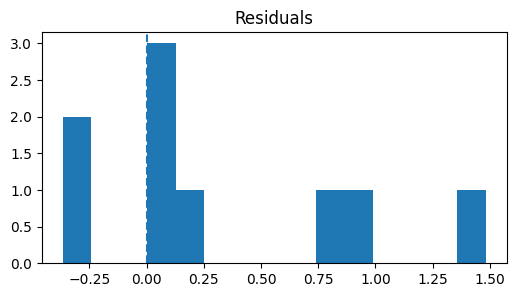

\n--- ACE Morgan (ECFP4,2048)


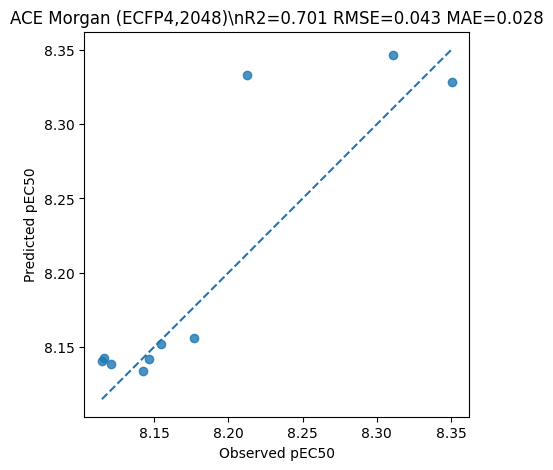

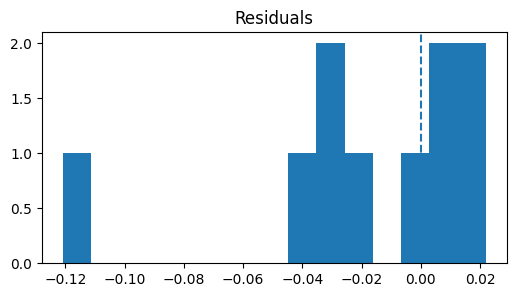

\n--- ACE MACCS


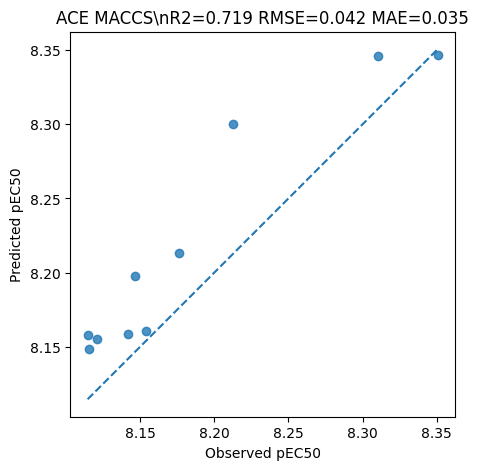

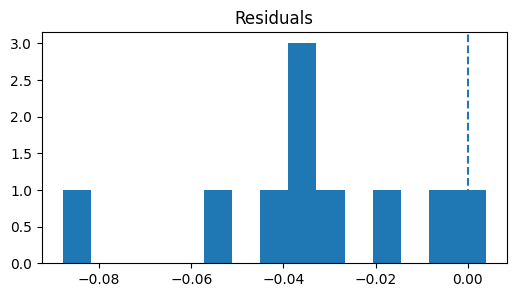

\n--- ACE RDKit (2048)


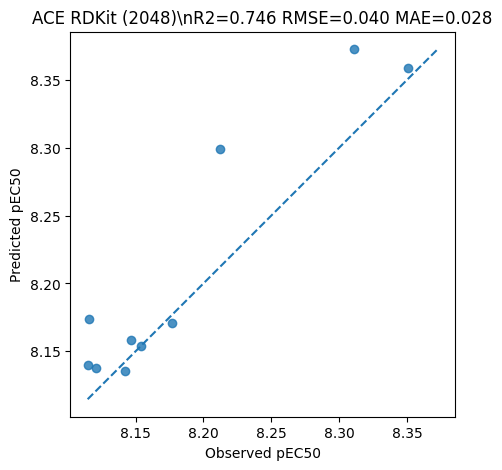

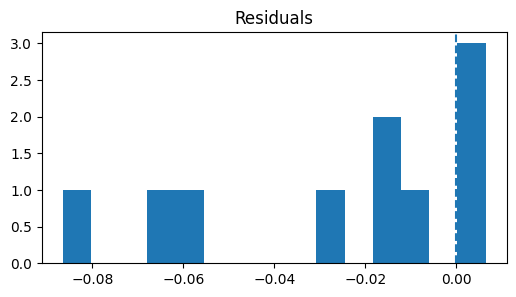

In [20]:
# Cell 2: visualize predicted vs observed and residuals for M2 and ACE each fingerprint
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

outdir = '/content/qsar_outputs'

def load_npz(dataset, fp):  # fp in 'morgan','maccs','rdk'
    d = np.load(os.path.join(outdir, f"{dataset}_fps_y.npz"))
    return d[fp], d['y']

def plot_one(X,y,title):
    Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42)
    m = RandomForestRegressor(n_estimators=250, random_state=42, n_jobs=-1); m.fit(Xtr,ytr); yp = m.predict(Xte)
    r2 = r2_score(yte,yp); rmse = mean_squared_error(yte,yp); rmse = rmse**0.5
    mae = mean_absolute_error(yte,yp)
    plt.figure(figsize=(5,5)); plt.scatter(yte,yp,alpha=0.8); mn=min(yte.min(),yp.min()); mx=max(yte.max(),yp.max())
    plt.plot([mn,mx],[mn,mx],'--'); plt.xlabel('Observed pEC50'); plt.ylabel('Predicted pEC50')
    plt.title(f"{title}\\nR2={r2:.3f} RMSE={rmse:.3f} MAE={mae:.3f}"); plt.gca().set_aspect('equal','box'); plt.show()
    plt.figure(figsize=(6,3)); res = yte-yp; plt.hist(res,bins=15); plt.axvline(0,linestyle='--'); plt.title('Residuals'); plt.show()

for dataset in ('M2','ACE'):
    for fp, label in [('morgan','Morgan (ECFP4,2048)'),('maccs','MACCS'),('rdk','RDKit (2048)')]:
        X,y = load_npz(dataset, fp)
        if X.shape[0] < 6:
            print(dataset, label, " -> too few samples:", X.shape[0]); continue
        print("\\n---", dataset, label)
        plot_one(X,y, f"{dataset} {label}")


In [21]:
# Cell 3: train on full ACE Morgan (or change to M2) and save model (.pkl) for download
import joblib, os, numpy as np
from sklearn.ensemble import RandomForestRegressor

outdir = '/content/qsar_outputs'
# choose dataset and fingerprint to save
dataset = 'ACE'     # change to 'M2' if desired
fp = 'morgan'       # 'morgan','maccs','rdk'
d = np.load(os.path.join(outdir, f"{dataset}_fps_y.npz"))
X, y = d[fp], d['y']
print("Training on", X.shape[0], "samples")
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X, y)
pkl_path = os.path.join(outdir, f"{dataset}_{fp}_rf.pkl")
joblib.dump(model, pkl_path)
print("Saved model to", pkl_path)
from google.colab import files
files.download(pkl_path)


Training on 49 samples
Saved model to /content/qsar_outputs/ACE_morgan_rf.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Cell 4: RandomizedSearchCV for M2 Morgan (small search)
import os, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
outdir = '/content/qsar_outputs'

d = np.load(os.path.join(outdir,'M2_fps_y.npz'))
X, y = d['morgan'], d['y']
print("Samples:", X.shape[0])
param_dist = {
    "n_estimators": [100,200,400,800],
    "max_depth": [None, 10, 20, 40],
    "max_features": ['sqrt','log2', 0.2, 0.5],
    "min_samples_split": [2,4,8],
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rs = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=24, cv=3, scoring='r2', n_jobs=-1, random_state=42, verbose=2)
rs.fit(X, y)
print("Best params:", rs.best_params_)
print("Best CV R2:", rs.best_score_)
pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').head()[['params','mean_test_score','std_test_score']]
# save best
import joblib
joblib.dump(rs.best_estimator_, os.path.join(outdir,'M2_morgan_rf_best.pkl'))
print("Saved best model to", os.path.join(outdir,'M2_morgan_rf_best.pkl'))
from google.colab import files
files.download(os.path.join(outdir,'M2_morgan_rf_best.pkl'))


Samples: 44
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params: {'n_estimators': 400, 'min_samples_split': 4, 'max_features': 0.2, 'max_depth': None}
Best CV R2: 0.06498155175691282
Saved best model to /content/qsar_outputs/M2_morgan_rf_best.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Cell 5: concatenate Morgan + MACCS for M2, evaluate RF (80/20 + 5-fold CV)
import os, numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
outdir = '/content/qsar_outputs'
d = np.load(os.path.join(outdir,'M2_fps_y.npz'))
Xm = d['morgan']; Xma = d['maccs']; y = d['y']
X_comb = np.hstack([Xm, Xma])
print("Combined shape:", X_comb.shape)
Xtr,Xte,ytr,yte = train_test_split(X_comb,y,test_size=0.2,random_state=42)
m = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1); m.fit(Xtr,ytr)
yp = m.predict(Xte); r2 = r2_score(yte,yp); rmse = mean_squared_error(yte,yp)**0.5
print("Holdout R2:", r2, "RMSE:", rmse)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(m, X_comb, y, cv=kf, scoring='r2', n_jobs=-1)
print("5-fold CV R2 mean/std:", cv_r2.mean(), cv_r2.std())


Combined shape: (44, 2215)
Holdout R2: 0.6596091086818461 RMSE: 0.4044148606862341
5-fold CV R2 mean/std: 0.6317654180027094 0.10900801655755525


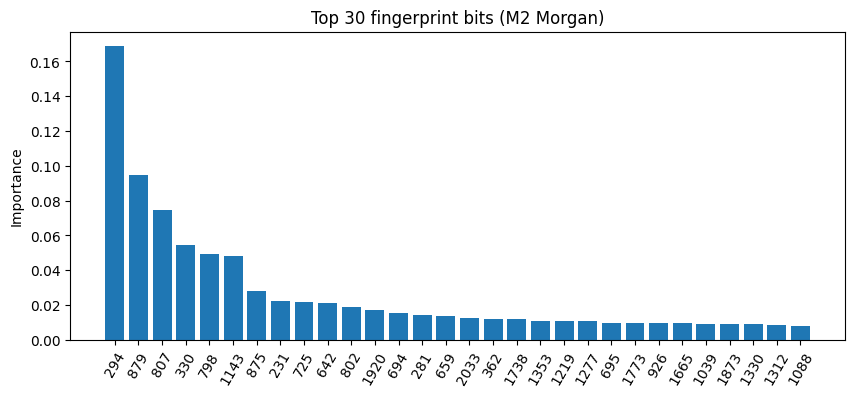

Top indices: [294, 879, 807, 330, 798, 1143, 875, 231, 725, 642, 802, 1920, 694, 281, 659, 2033, 362, 1738, 1353, 1219, 1277, 695, 1773, 926, 1665, 1039, 1873, 1330, 1312, 1088]


In [24]:
# Cell 6: compute feature importances for a trained model (e.g. M2 Morgan)
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

outdir = '/content/qsar_outputs'
d = np.load(os.path.join(outdir,'M2_fps_y.npz'))
X, y = d['morgan'], d['y']
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42)
model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1); model.fit(Xtr,ytr)
fi = model.feature_importances_
idx = fi.argsort()[::-1][:30]   # top 30 bits
plt.figure(figsize=(10,4)); plt.bar(range(len(idx)), fi[idx]); plt.xticks(range(len(idx)), idx, rotation=60)
plt.title("Top 30 fingerprint bits (M2 Morgan)"); plt.ylabel("Importance"); plt.show()
print("Top indices:", idx.tolist())
